## Homology
A surface-level way to examine the networks is by purely looking at the homology for it. This view gives us a way to analyze the topological structure of the knowledge network and understand what parts of it is meaningful.

#### Preliminaries

In [1]:
# load some packages
import Gavin.utils.random_complexes as rc
import Gavin.utils.compare_barcodes as cb
import Gavin.utils.make_network as mn
import matplotlib.pyplot as plt
import Gavin.utils.plots as pl
import networkx as nx
import seaborn as sns
import pandas as pd
import oatpy as oat
import numpy as np

# config
FIELD = 'Zoology'  # field 608
CONCEPT_FILE = 'https://www.dropbox.com/scl/fi/a1t16rtialcw03n50ffkc/concepts_Zoology_608.csv.gz?rlkey=vjv60sfbhofbgvzfzdkrlurl1&st=ur4m854l&dl=1'
MIN_RELEVANCE = 0.7
MIN_YEAR = 1920
MIN_FREQ = 0.0001
MAX_FREQ = 0.001
MAX_DIM = 6
N = 10  # number of iterations for each null model

#### Network
We'll create and threshold a network that we can then base everything off of.

In [2]:
G = mn.gen_concept_network(
        CONCEPT_FILE,
        min_relevance=MIN_RELEVANCE,
        min_year=MIN_YEAR,
        min_articles=MIN_FREQ, # 0.006%
        max_articles=MAX_FREQ, # 0.05%
        normalize_year=True
    ) # use a filtered data file

#### Homology
Calculate homology for the network.

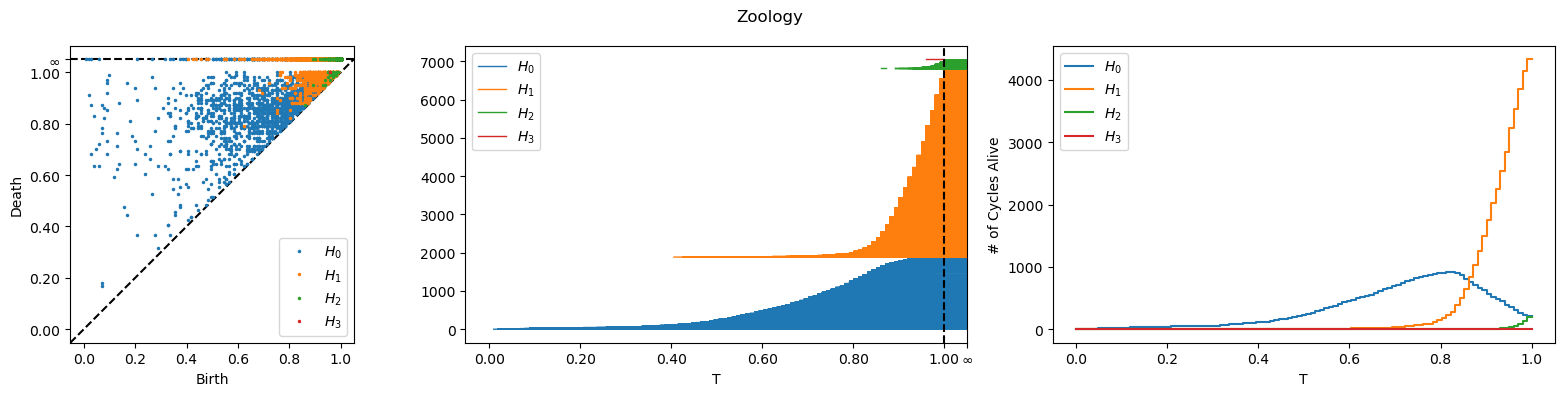

In [3]:
# create dissimilarity matrix
adj = mn.adj_matrix(
        G,
        'norm_year',
        True,
        None,
    )
# setup the problem
factored = oat.rust.FactoredBoundaryMatrixVr( # two functions that do this, idk what the other one is
        dissimilarity_matrix=adj,
        homology_dimension_max=MAX_DIM
    )
# solve homology
homology = factored.homology( # solve homology
        return_cycle_representatives=False,
        return_bounding_chains=False,
    )
# get simplicies
simplicies = factored.indices_boundary_matrix()
simplicies['dimension'] = simplicies['simplex'].str.len() - 1

# clear up memory
del adj, factored

# plot setup
fig, axs = plt.subplots(1, 3, width_ratios=[1, 1.5, 1.5])
fig.suptitle(FIELD)
fig.set_figwidth(16)
fig.set_figheight(4)

# make plots
pl.plot_persistance_diagram(homology, axs[0])
pl.plot_barcode(homology, axs[1])
pl.plot_betti_curve(homology, axs[2])

# final things
fig.tight_layout()

#### Erdos Renyi Complex
Make an ER graph with the same number of nodes, number of edges, and edge weights as the graph and find its homology too.

This is a null model where we change both the structure of the graph and mix up the weighting of edges, so it should mess up the homology the most.

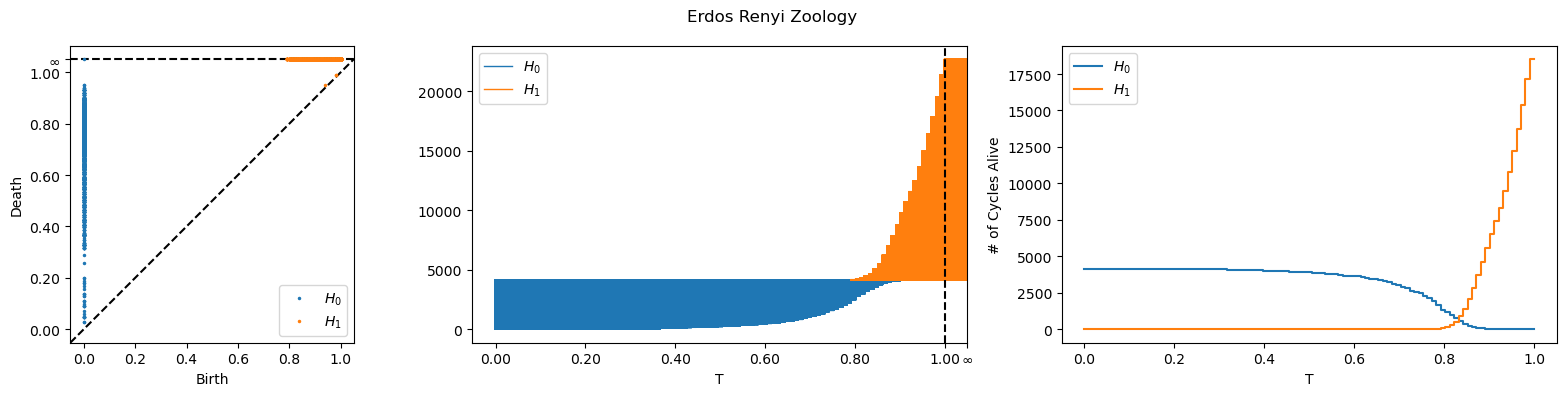

In [4]:
# config
seeds = np.arange(N)  # len(seeds) == N

# store results
er_simplicies = []
er_homology = []

# loop and get results
for s in seeds:
    # adjacency matrix
    er_adj = rc.erdos_renyi_complex(
            len(G.nodes),  # same number of nodes as initial graph
            edge_weights=np.array(list(nx.get_edge_attributes(G, 'norm_year').values())),  # same number of edges as initial graph
            seed=s,
        )
    # setup the problem
    er_factored = oat.rust.FactoredBoundaryMatrixVr( # two functions that do this, idk what the other one is
            dissimilarity_matrix=er_adj,
            homology_dimension_max=MAX_DIM
        )
    # solve homology
    er_iter_homology = er_factored.homology( # solve homology
            return_cycle_representatives=False,
            return_bounding_chains=False,
        )
    # get simplicies
    er_iter_simplicies = er_factored.indices_boundary_matrix()
    er_iter_simplicies['dimension'] = er_iter_simplicies['simplex'].str.len() - 1

    # store results
    er_simplicies.append(er_iter_simplicies)
    er_homology.append(er_iter_homology)

# clear up memory
del er_adj, er_factored, er_iter_homology, er_iter_simplicies 

# plot setup
fig, axs = plt.subplots(1, 3, width_ratios=[1, 1.5, 1.5])
fig.suptitle('Erdos Renyi ' + FIELD)
fig.set_figwidth(16)
fig.set_figheight(4)

# make plots
pl.plot_persistance_diagram(er_homology[-1], axs[0])
pl.plot_barcode(er_homology[-1], axs[1])
pl.plot_betti_curve(er_homology[-1], axs[2])

# final things
fig.tight_layout()

#### Edge Swap
We'll swap a random fraction of the edges in the network but keep the weights the same.

This (as much as possible) lets us analyze the extent to which the homology is a function of the structure of the graph.

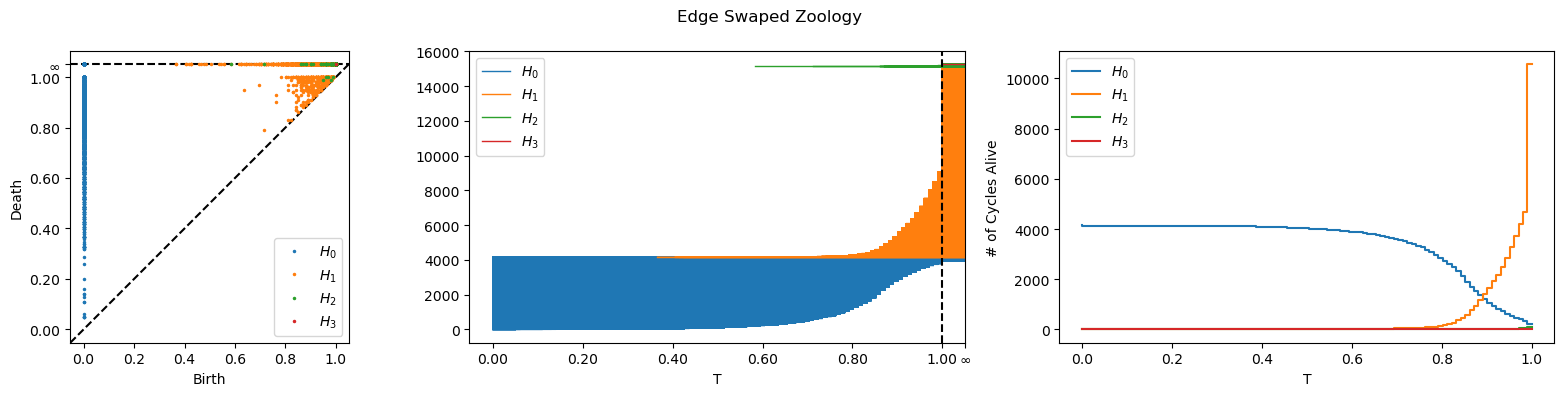

In [5]:
# config
seeds = np.arange(N)  # len(seeds) == N, TODO
p = 1.  # fraction of edges swapped
num_swaps = int(len(G) * p)

# store results
es_simplicies = []  # es=edge swap
es_homology = []

# loop and get results
for s in seeds:
    # swap edges
    es_G = nx.double_edge_swap(G.copy(), num_swaps, num_swaps * 2) #, seed=s)
    es_adj = mn.adj_matrix(
            es_G,
            'norm_year',
            True,
            0.
        )
    # setup the problem
    es_factored = oat.rust.FactoredBoundaryMatrixVr( # two functions that do this, idk what the other one is
            dissimilarity_matrix=es_adj,
            homology_dimension_max=MAX_DIM
        )
    # solve homology
    es_iter_homology = es_factored.homology( # solve homology
            return_cycle_representatives=False,
            return_bounding_chains=False,
        )
    # get simplicies
    es_iter_simplicies = es_factored.indices_boundary_matrix()
    es_iter_simplicies['dimension'] = es_iter_simplicies['simplex'].str.len() - 1

    # store results
    es_simplicies.append(es_iter_simplicies)
    es_homology.append(es_iter_homology)

# clear up memory
del es_adj, es_factored, es_iter_homology, es_iter_simplicies 

# plot setup
fig, axs = plt.subplots(1, 3, width_ratios=[1, 1.5, 1.5])
fig.suptitle('Edge Swaped ' + FIELD)
fig.set_figwidth(16)
fig.set_figheight(4)

# make plots
pl.plot_persistance_diagram(es_homology[-1], axs[0])
pl.plot_barcode(es_homology[-1], axs[1])
pl.plot_betti_curve(es_homology[-1], axs[2])

# final things
fig.tight_layout()

#### Weight Swap
We'll mix up the weights in the network and keep the structure of the graph the same.

This should show us how the homology we get is dependent on the filtration values in the network.

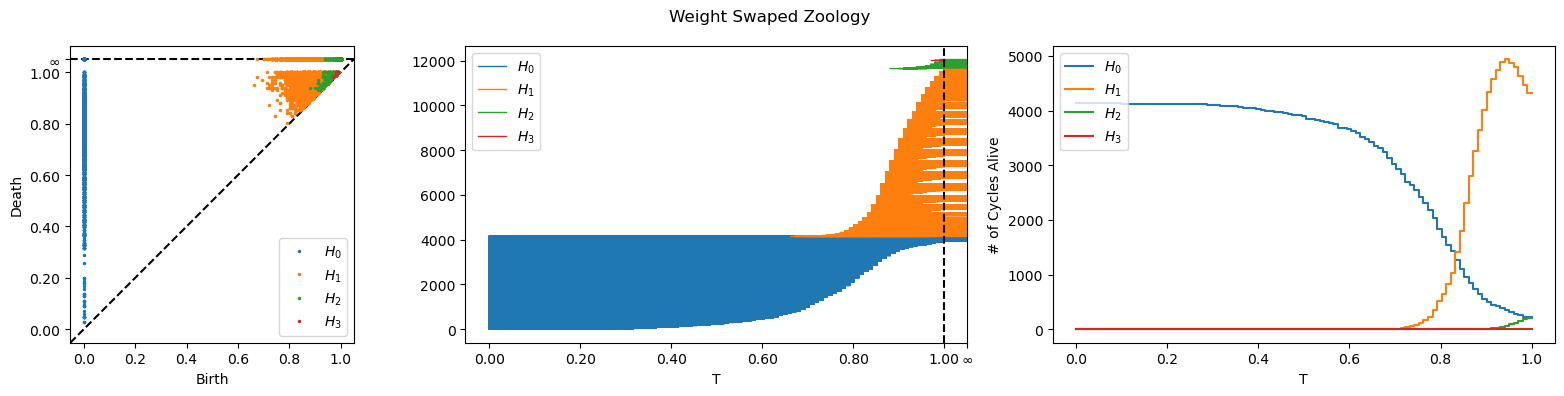

In [6]:
# config
seeds = np.arange(N)  # len(seeds) == N

# store results
ws_simplicies = []  # es=edge swap
ws_homology = []

# loop and get results
for s in seeds:
    # swap edges
    ws_G = rc.shuffle_edge_weights(G, seed=s)
    ws_adj = mn.adj_matrix(
            ws_G,
            'norm_year',
            True,
            0.
        )
    # setup the problem
    ws_factored = oat.rust.FactoredBoundaryMatrixVr( # two functions that do this, idk what the other one is
            dissimilarity_matrix=ws_adj,
            homology_dimension_max=MAX_DIM
        )
    # solve homology
    ws_iter_homology = ws_factored.homology( # solve homology
            return_cycle_representatives=False,
            return_bounding_chains=False,
        )
    # get simplicies
    ws_iter_simplicies = ws_factored.indices_boundary_matrix()
    ws_iter_simplicies['dimension'] = ws_iter_simplicies['simplex'].str.len() - 1

    # store results
    ws_simplicies.append(ws_iter_simplicies)
    ws_homology.append(ws_iter_homology)

# clear up memory
del ws_adj, ws_factored, ws_iter_homology, ws_iter_simplicies 

# plot setup
fig, axs = plt.subplots(1, 3, width_ratios=[1, 1.5, 1.5])
fig.suptitle('Weight Swaped ' + FIELD)
fig.set_figwidth(16)
fig.set_figheight(4)

# make plots
pl.plot_persistance_diagram(ws_homology[-1], axs[0])
pl.plot_barcode(ws_homology[-1], axs[1])
pl.plot_betti_curve(ws_homology[-1], axs[2])

# final things
fig.tight_layout()

#### Comparison
Compare the results for everything and see how they differ.

,,actual,erdos renyi,edge swap,weight swap
feature,value,,,,
$S_0$,Count,4146.0,4146.000000,4146.000000,4146.000000
,Standard Deviation,NaN,0.000000,0.000000,0.000000
$S_1$,Count,22856.0,22856.000000,22856.000000,22856.000000
,Standard Deviation,NaN,0.000000,0.000000,0.000000
$S_2$,Count,28871.0,219.000000,11180.300000,28871.000000
,Standard Deviation,NaN,11.899580,100.134959,0.000000
$S_3$,Count,25890.0,0.000000,3250.400000,25890.000000
,Standard Deviation,NaN,0.000000,126.829176,0.000000
$S_4$,Count,21213.0,0.000000,644.400000,21213.000000


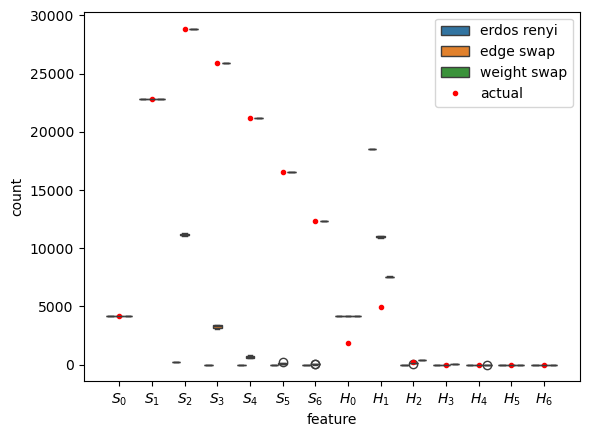

In [7]:
# get actual counts
actual_simplex_counts = [(simplicies['dimension'] == dim).sum() for dim in range(MAX_DIM + 1)]
actual_homology_counts = [(homology['dimension'] == dim).sum() for dim in range(MAX_DIM + 1)]

# get counts
def rc_count(df_list, max_dim=MAX_DIM):
    # setup
    counts = []

    # get counts
    for dim in range(max_dim + 1):
        counts.append([(df['dimension'] == dim).sum() for df in df_list])

    return counts
er_simplex_counts = rc_count(er_simplicies)
er_homology_counts = rc_count(er_homology)
es_simplex_counts = rc_count(es_simplicies)
es_homology_counts = rc_count(es_homology)
ws_simplex_counts = rc_count(ws_simplicies)
ws_homology_counts = rc_count(ws_homology)

# boxplot setup
boxplot_df = pd.DataFrame(columns=['feature', 'process', 'count'])
features = np.ravel([[f'${L}_{s}$' for s in range(MAX_DIM + 1)] for L in ['S', 'H']])
processes = ['erdos renyi', 'edge swap', 'weight swap']
counts = [
        er_simplex_counts + er_homology_counts,
        es_simplex_counts + es_homology_counts,
        ws_simplex_counts + ws_homology_counts,
    ]

# loop over each process
for p, c in zip(processes, counts):
    process_df = pd.DataFrame({
            'feature': features,
            'count': c,
        }).explode('count')
    process_df['process'] = p

    # add to df
    boxplot_df = pd.concat((boxplot_df, process_df))
boxplot_df = boxplot_df.reset_index(drop=True)

# plot
ax = plt.subplot()
sns.boxplot(data=boxplot_df, x='feature', y='count', hue='process', ax=ax)
ax.plot(actual_simplex_counts + actual_homology_counts, 'r.', label='actual')
ax.legend()

# colect into a thing
summary = lambda counts: ([np.mean(c) for c in counts], [np.std(c) for c in counts])
column = lambda simplex_means, simplex_stdevs, homology_means, homology_simplicies: np.ravel((
        np.ravel((simplex_means, simplex_stdevs), 'F'),
        np.ravel((homology_means, homology_simplicies), 'F'),
    ))
actual_column = column(actual_simplex_counts, np.full(MAX_DIM+1, np.nan), actual_homology_counts, np.full(MAX_DIM+1, np.nan))
er_column = column(*summary(er_simplex_counts), *summary(er_homology_counts))
es_column = column(*summary(es_simplex_counts), *summary(es_homology_counts))
ws_column = column(*summary(ws_simplex_counts), *summary(ws_homology_counts))

# get summary
res_df = pd.DataFrame(data={
        'feature': np.ravel([[(f'${L}_{s}$', '') for s in range(MAX_DIM + 1)] for L in ['S', 'H']]),
        'value': np.ravel([('Count', 'Standard Deviation') for _ in range(MAX_DIM * 2 + 2)]),
        'actual': actual_column,
        'erdos renyi': er_column,
        'edge swap': es_column,
        'weight swap': ws_column,
    }).set_index(['feature', 'value'])

res_df

#### Distances
Use persistence images to find the distance between different the actual graph and the different null models.

,actual,erdos renyi 1,erdos renyi 2,erdos renyi 3,erdos renyi 4,erdos renyi 5,erdos renyi 6,erdos renyi 7,erdos renyi 8,erdos renyi 9,...,weight swap 1,weight swap 2,weight swap 3,weight swap 4,weight swap 5,weight swap 6,weight swap 7,weight swap 8,weight swap 9,weight swap 10
actual,0.000000,2667.627023,2670.570316,2661.170671,2665.594185,1304.794994,899.332883,2666.727182,2188.093658,2665.652146,...,984.483978,980.790467,983.428963,980.460839,981.445541,992.183708,971.287804,971.190172,967.536669,984.307760
erdos renyi 1,2667.627023,0.000000,11.980343,6.654981,5.322893,1393.537143,1810.602009,5.924824,492.227805,4.083664,...,1810.510294,1807.760009,1797.963355,1807.109903,1799.458583,1799.379170,1814.210153,1813.042360,1811.241116,1801.308392
erdos renyi 2,2670.570316,11.980343,0.000000,14.368846,9.012724,1398.055066,1814.759887,7.028493,497.562644,9.531744,...,1810.956999,1808.291788,1798.557054,1807.643168,1800.056647,1799.848929,1814.783399,1813.628614,1811.887422,1801.846979
erdos renyi 3,2661.170671,6.654981,14.368846,0.000000,5.775036,1387.310807,1804.346397,7.484747,486.091915,5.244545,...,1804.063579,1801.310926,1791.517503,1800.666270,1793.008802,1792.935929,1807.761642,1806.597215,1804.791814,1794.862355
erdos renyi 4,2665.594185,5.322893,9.012724,5.775036,0.000000,1392.186234,1809.124723,2.211823,491.167926,1.717397,...,1807.622319,1804.900440,1795.134299,1804.261662,1796.625268,1796.504950,1811.369519,1810.212764,1808.428632,1798.459041
erdos renyi 5,1304.794994,1393.537143,1398.055066,1387.310807,1392.186234,0.000000,420.609632,1393.459353,903.447026,1392.089611,...,699.601517,690.006553,675.867851,688.328695,676.432638,689.562602,689.617082,687.164660,679.743403,683.321988
erdos renyi 6,899.332883,1810.602009,1814.759887,1804.346397,1809.124723,420.609632,0.000000,1810.345401,1322.402174,1809.048664,...,588.609700,577.641883,565.859185,575.436628,565.445797,583.943720,571.207665,568.555088,559.581682,573.408260
erdos renyi 7,2666.727182,5.924824,7.028493,7.484747,2.211823,1393.459353,1810.345401,0.000000,492.554829,2.577383,...,1808.423008,1805.712258,1795.948036,1805.067118,1797.442924,1797.304995,1812.183497,1811.024445,1809.249739,1799.266777
erdos renyi 8,2188.093658,492.227805,497.562644,486.091915,491.167926,903.447026,1322.402174,492.554829,0.000000,491.022307,...,1376.144798,1371.755321,1360.664700,1370.957086,1362.010575,1364.719221,1377.132527,1375.684078,1372.607707,1365.042449
erdos renyi 9,2665.652146,4.083664,9.531744,5.244545,1.717397,1392.089611,1809.048664,2.577383,491.022307,0.000000,...,1807.867181,1805.138761,1795.361117,1804.492374,1796.855371,1796.744149,1811.600842,1810.438632,1808.651503,1798.691049


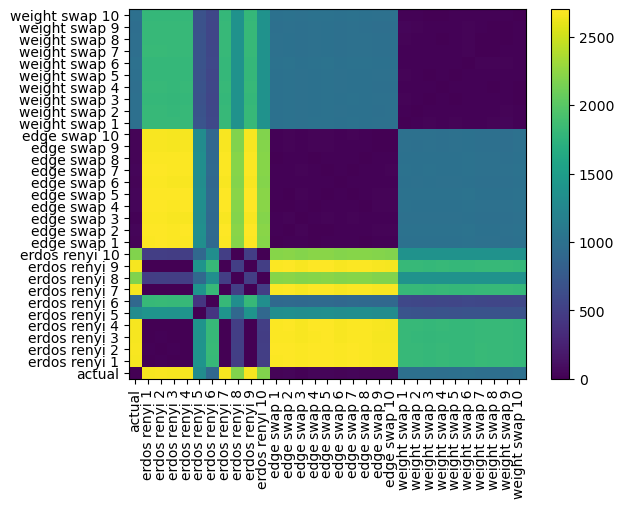

In [8]:
# get distances
dist_mat_df = cb.barcode_distance_matrix(
        [homology] + er_homology + es_homology + ws_homology,
        cb.persistance_image_distance,
        labels=['actual'] + [f'erdos renyi {i}' for i in range(1, N+1)] + [f'edge swap {i}' for i in range(1, N+1)] + [f'weight swap {i}' for i in range(1, N+1)],
        dim=1
    )

# plot it
fig, ax = plt.subplots()
cf = ax.pcolormesh(dist_mat_df.index, dist_mat_df.index, dist_mat_df)
ax.tick_params(axis='x', rotation=90)
fig.colorbar(cf)

dist_mat_df

#### Dimension Reduction
Use PCoA to place this onto a 2D plane and plot locations.

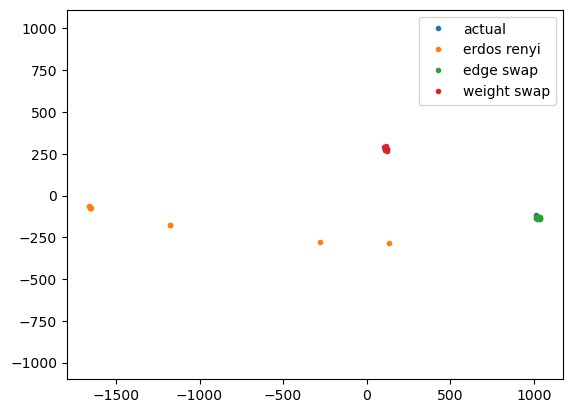

In [9]:
# PCOA formula
dist_mat = dist_mat_df.to_numpy()
n = dist_mat.shape[0]
m = 2  # number of vectors we're looking for (want to plot in 2d space)

# find coords
C = np.eye(n) - 1/n * np.ones((n, n))  # centering matrix
B = -1/2 * C @ dist_mat**2 @ C  # double centering 
vals, vecs = np.linalg.eig(B)  # eigenvalue decompsisition
idxs = (-np.abs(vals)).argsort()[:m]
lambda_m = np.diag(vals[idxs]).real
E_m = vecs[:, idxs].real
coords = E_m @ lambda_m**(1/2)

# make dataframe
coords_df = pd.DataFrame(coords, index=dist_mat_df.index, columns=['x', 'y'])

# plot it
fig, ax = plt.subplots()
ax.axis('equal')
ax.plot(coords_df.iloc[0, 0], coords_df.iloc[0, 1], '.', label='actual')
ax.plot(coords_df.iloc[1:N+1, 0], coords_df.iloc[1:N+1, 1], '.', label='erdos renyi')
ax.plot(coords_df.iloc[N+1:2*N+1, 0], coords_df.iloc[N+1:2*N+1, 1], '.', label='edge swap')
ax.plot(coords_df.iloc[2*N+1:3*N+1, 0], coords_df.iloc[2*N+1:3*N+1, 1], '.', label='weight swap')
ax.legend()